In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.exceptions import ConvergenceWarning #GEREKSİZ WARNİNGLERDEN KURTULMAK İÇİN
import warnings
from sklearn.metrics import mean_squared_error


In [21]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning) #İşlemler sırasında çıkan uyarılardan kurtulmak için

In [22]:
df = pd.read_csv(r'C:\Users\brain\Desktop\sample_data\insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [23]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [24]:
# Verilen target değişkene göre sayısal olarak verileri analiz eden method
def num_target_analyse(dataframe,target, col_name):
    print(dataframe.groupby(col_name).agg({target : 'mean'}))
def cat_target_analyse(dataframe, target, col_name):
    print(dataframe.groupby(col_name).agg({target : 'value_counts'}))

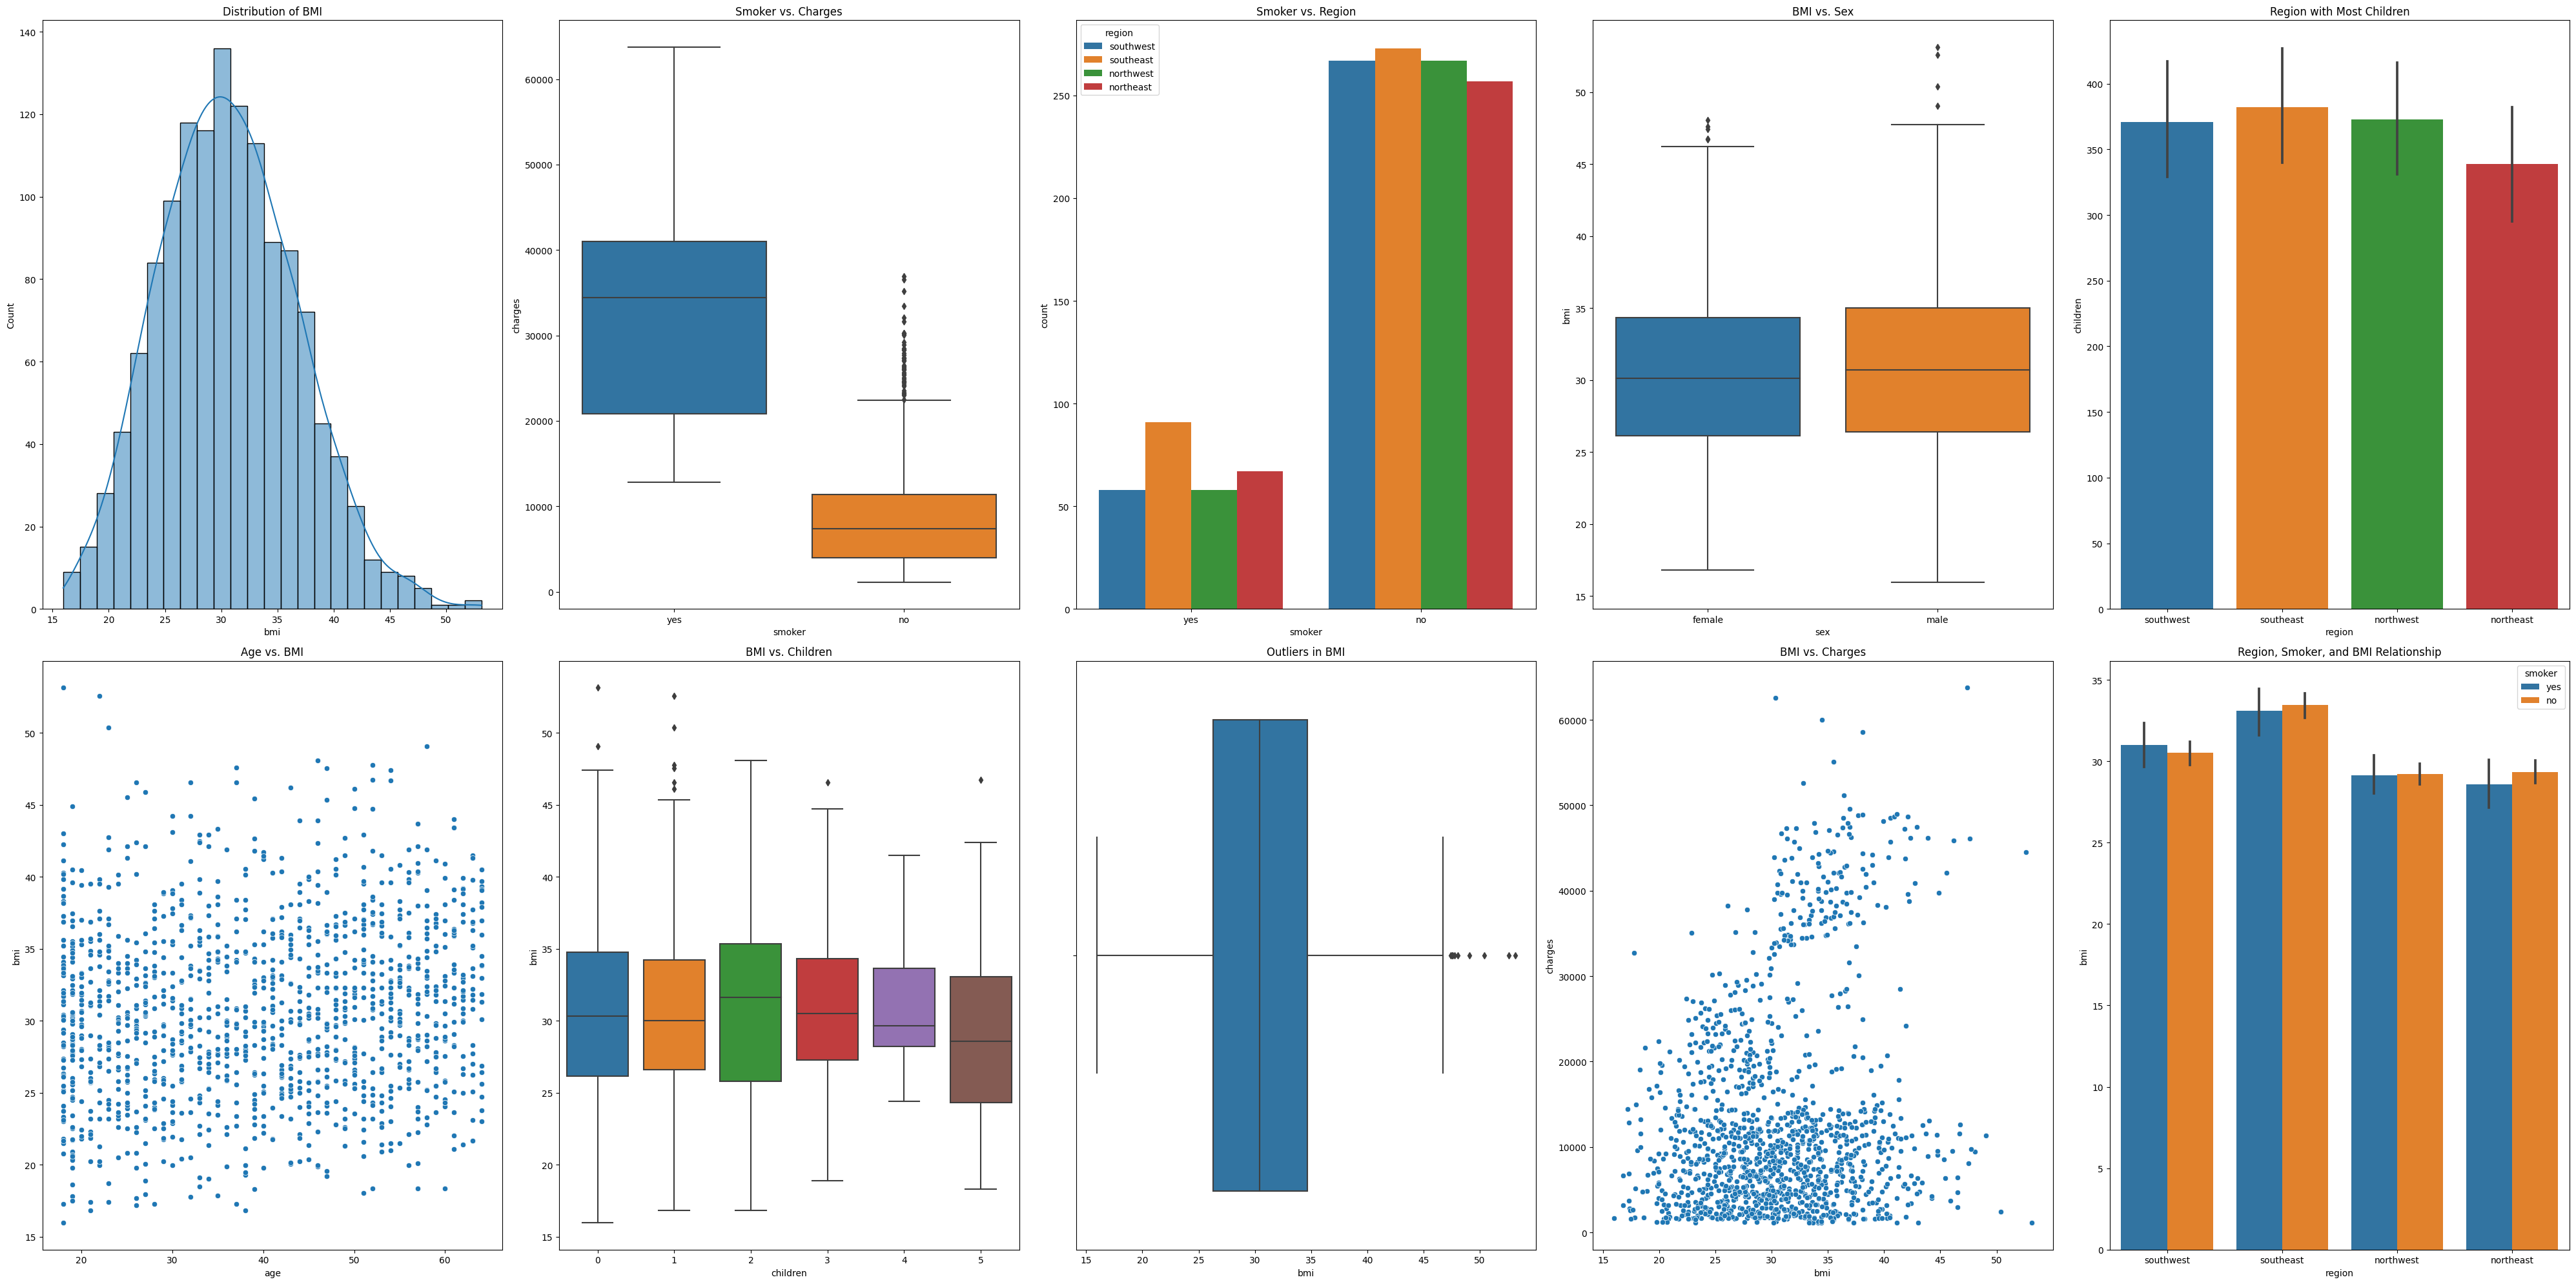

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure and subplots
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(40, 20))
fig.subplots_adjust(hspace=0.5)

# Examine the distribution of BMI
sns.histplot(df['bmi'], ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Distribution of BMI')

# Examine the relationship between "smoker" and "charges"
sns.boxplot(x='smoker', y='charges', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Smoker vs. Charges')

# Examine the relationship between "smoker" and "region"
sns.countplot(x='smoker', hue='region', data=df, ax=axes[0, 2])
axes[0, 2].set_title('Smoker vs. Region')

# Examine the relationship between "bmi" and "sex"
sns.boxplot(x='sex', y='bmi', data=df, ax=axes[0, 3])
axes[0,3].set_title('BMI vs. Sex')

# Find the "region" with the most "children"
sns.barplot(x='region', y='children', data=df, estimator=sum, ax=axes[0,4])
axes[0,4].set_title('Region with Most Children')

# Examine the relationship between "age" and "bmi"
sns.scatterplot(x='age', y='bmi', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Age vs. BMI')

# Examine the relationship between "bmi" and "children"
sns.boxplot(x='children', y='bmi', data=df, ax=axes[1,1])
axes[1,1].set_title('BMI vs. Children')

# Examine for outliers in the "bmi" variable
sns.boxplot(x=df['bmi'], ax=axes[1,2])
axes[1,2].set_title('Outliers in BMI')

# Examine the relationship between "bmi" and "charges"
sns.scatterplot(x='bmi', y='charges', data=df, ax=axes[1,3])
axes[1,3].set_title('BMI vs. Charges')

# Examine the relationship between "region", "smoker", and "bmi"
sns.barplot(x='region', y='bmi', hue='smoker', data=df, ax=axes[1,4])
axes[1,4].set_title('Region, Smoker, and BMI Relationship')

# Adjust the layout
plt.tight_layout()

# Show all plots
plt.show()


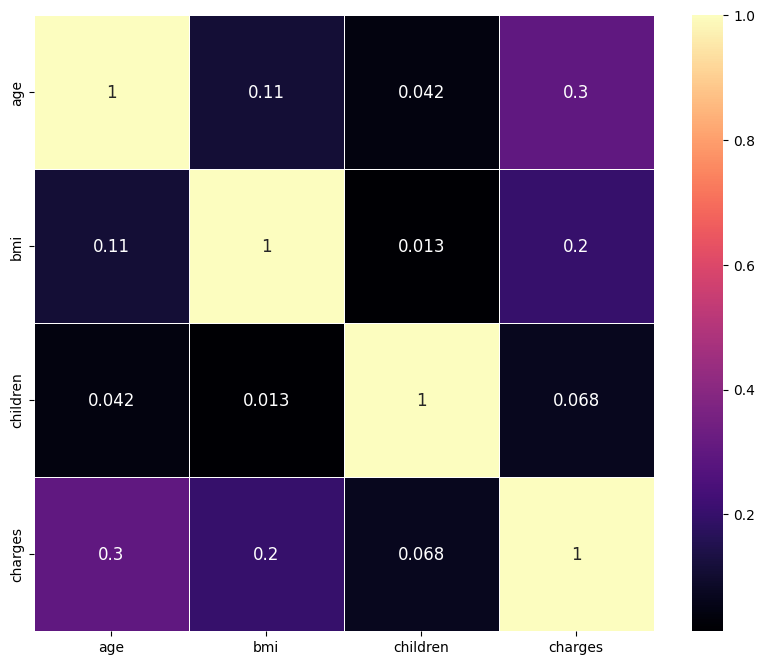

In [32]:

# Değişkenler arasında ciddi bir doğrusallık yok.
def correlation_matrix(df):
    fig = plt.figure()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df.corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='magma')
    plt.show(block=True)

numerical_df = df.select_dtypes(include=['float64', 'int64'])  # Sadece sayısal sütunları seç
correlation_matrix(numerical_df)


In [33]:

def grab_col_names(dataframe, cat_th=5, car_th=20):
    cat_col= [col for col in dataframe.columns if dataframe[col].dtypes == 'O']
    num_but_cat = [col for col in dataframe.columns if dataframe[col].dtypes != 'O' and dataframe[col].nunique() < cat_th]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].dtypes == 'O' and dataframe[col].nunique() > car_th]
    cat_col= cat_col + num_but_cat
    cat_col = [col for col in cat_col if col not in cat_but_car]

    #Num cols
    num_col= [col for col in dataframe.columns if dataframe[col].dtypes != 'O']
    num_col = [col for col in num_col if col not in num_but_cat]
    return cat_col, num_col

cat_cols, num_cols= grab_col_names(df)
print(f'Cat cols: {cat_cols}')
print(f'Numerical columns: {num_cols}')



Cat cols: ['sex', 'smoker', 'region']
Numerical columns: ['age', 'bmi', 'children', 'charges']


In [34]:
# Na olan değişken yok
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [35]:
# Outlier değerlerinin alt ve üst limitlerini bul

def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quantile1= dataframe[col_name].quantile(q1)
    quantile3= dataframe[col_name].quantile(q3)
    IQR= quantile3-quantile1
    lower_lim= quantile1-1.5*IQR
    upper_lim= quantile3+1.5*IQR
    return lower_lim,upper_lim

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    outliers = dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)]

    if outliers.any(axis=None):
        num_outliers = outliers.shape[0]
        print(f'{col_name} has {num_outliers} outliers:')
        print(outliers)
        return True
    else:
        print(f'{col_name} has no outliers.')
        return False

for column in num_cols:
    check_outlier(df, column)




age has no outliers.
bmi has 9 outliers:
      age     sex    bmi  children smoker     region      charges
116    58    male  49.06         0     no  southeast  11381.32540
286    46  female  48.07         2     no  northeast   9432.92530
401    47    male  47.52         1     no  southeast   8083.91980
543    54  female  47.41         0    yes  southeast  63770.42801
847    23    male  50.38         1     no  southeast   2438.05520
860    37  female  47.60         2    yes  southwest  46113.51100
1047   22    male  52.58         1    yes  southeast  44501.39820
1088   52    male  47.74         1     no  southeast   9748.91060
1317   18    male  53.13         0     no  southeast   1163.46270
children has no outliers.
charges has 139 outliers:
      age     sex     bmi  children smoker     region      charges
14     27    male  42.130         0    yes  southeast  39611.75770
19     30    male  35.300         0    yes  southwest  36837.46700
23     34  female  31.920         1    yes  no

In [36]:
def remove_outlier(dataframe, col_name):
    low, up = outlier_thresholds(dataframe, col_name)
    df_without_outliers= dataframe[~((dataframe[col_name] < low) | (dataframe[col_name] > up))]
    return df_without_outliers
df_no_outliers = df.copy()
for col in num_cols:
  df_no_outliers = remove_outlier(df_no_outliers, col)

# Sonuçları görüntüle
print(df_no_outliers)

      age     sex     bmi  children smoker     region      charges
0      19  female  27.900         0    yes  southwest  16884.92400
1      18    male  33.770         1     no  southeast   1725.55230
2      28    male  33.000         3     no  southeast   4449.46200
3      33    male  22.705         0     no  northwest  21984.47061
4      32    male  28.880         0     no  northwest   3866.85520
...   ...     ...     ...       ...    ...        ...          ...
1333   50    male  30.970         3     no  northwest  10600.54830
1334   18  female  31.920         0     no  northeast   2205.98080
1335   18  female  36.850         0     no  southeast   1629.83350
1336   21  female  25.800         0     no  southwest   2007.94500
1337   61  female  29.070         0    yes  northwest  29141.36030

[1191 rows x 7 columns]


In [37]:
# Encoding
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df_encoded = one_hot_encoder(df_no_outliers, cat_cols, True)
print(df_encoded)



      age     bmi  children      charges  sex_male  smoker_yes  \
0      19  27.900         0  16884.92400     False        True   
1      18  33.770         1   1725.55230      True       False   
2      28  33.000         3   4449.46200      True       False   
3      33  22.705         0  21984.47061      True       False   
4      32  28.880         0   3866.85520      True       False   
...   ...     ...       ...          ...       ...         ...   
1333   50  30.970         3  10600.54830      True       False   
1334   18  31.920         0   2205.98080     False       False   
1335   18  36.850         0   1629.83350     False       False   
1336   21  25.800         0   2007.94500     False       False   
1337   61  29.070         0  29141.36030     False        True   

      region_northwest  region_southeast  region_southwest  
0                False             False              True  
1                False              True             False  
2                False  

In [38]:
# standardScaler nesnesi oluşturma
scaler = StandardScaler()

# Robust Scaling işlemi
df_encoded[num_cols] = scaler.fit_transform(df_encoded[num_cols])

# Ölçeklendirilmiş veriyi gösterme
print("Scaled Data:")
print(df_encoded)

Scaled Data:
           age       bmi  children   charges  sex_male  smoker_yes  \
0    -1.424190 -0.356784 -0.894220  0.972086     False        True   
1    -1.495361  0.643537 -0.071814 -1.137965      True       False   
2    -0.783654  0.512320  1.572998 -0.758821      True       False   
3    -0.427801 -1.242076 -0.894220  1.681898      True       False   
4    -0.498972 -0.189779 -0.894220 -0.839914      True       False   
...        ...       ...       ...       ...       ...         ...   
1333  0.782101  0.166382  1.572998  0.097356      True       False   
1334 -1.495361  0.328274 -0.894220 -1.071094     False       False   
1335 -1.495361  1.168407 -0.894220 -1.151288     False       False   
1336 -1.281849 -0.714650 -0.894220 -1.098658     False       False   
1337  1.564978 -0.157401 -0.894220  2.678074     False        True   

      region_northwest  region_southeast  region_southwest  
0                False             False              True  
1                False  

In [39]:
X=df_encoded.drop('charges', axis=1)
y=df_encoded['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 8
[LightGBM] [Info] Start training from score 0.026802
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 319
[LightGBM] [Info] Number of data points in the train set: 952, number of used features: 8
[LightGBM] [Info] Start training from score 0.002670
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set

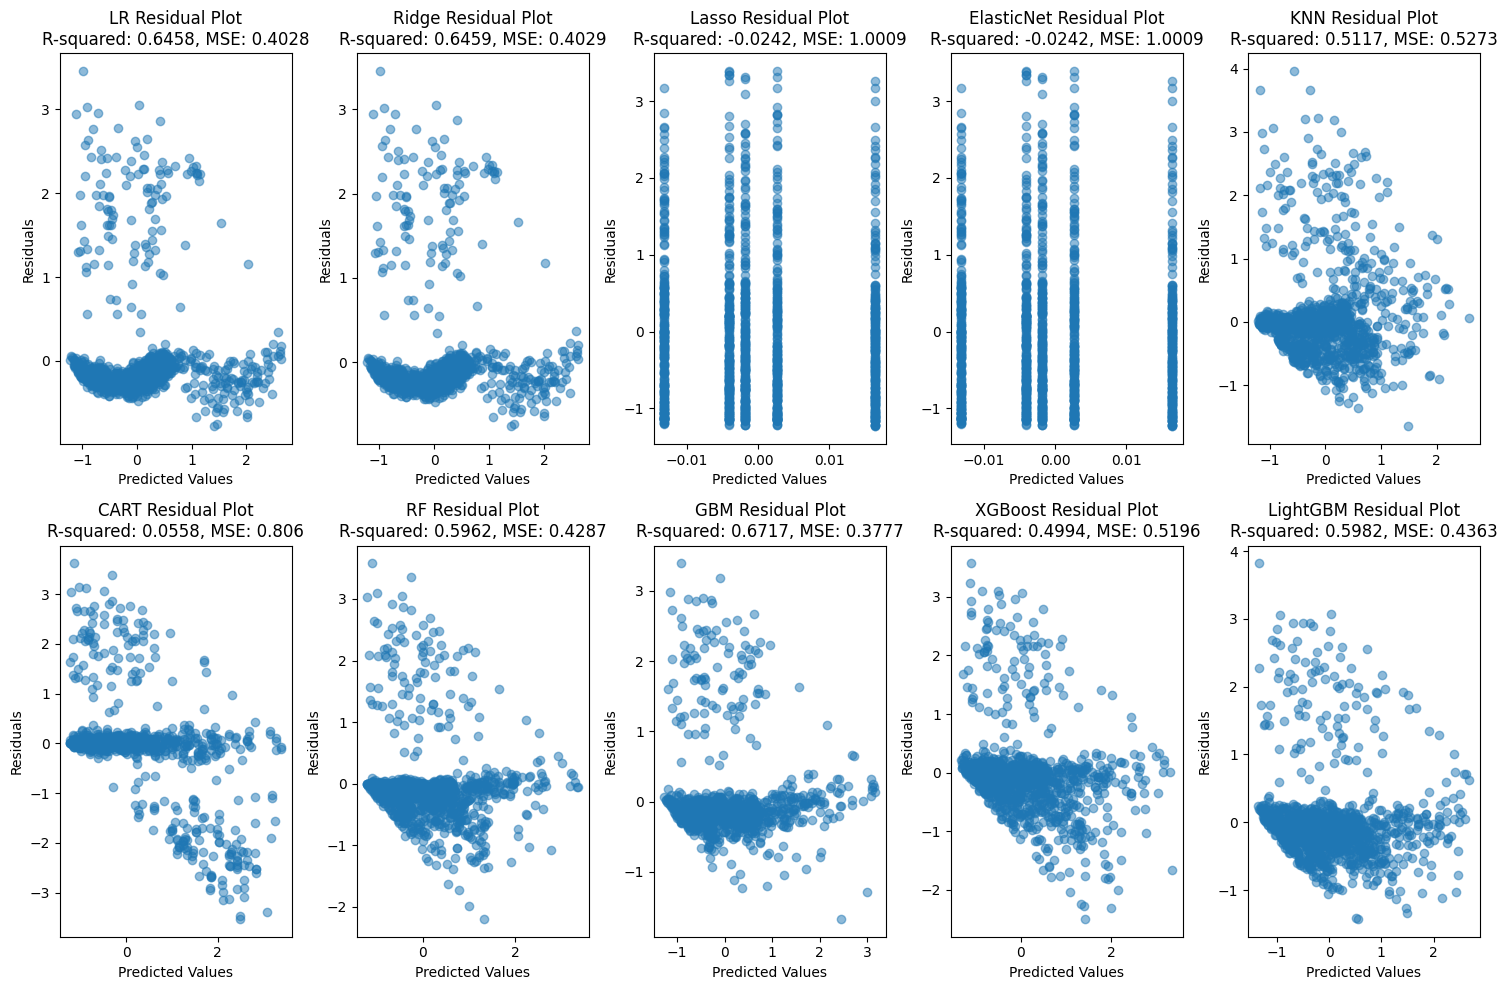

In [40]:
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_predict

# Model isimleri ve nesneleri
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]


# Subplot düzeni
num_rows = 2
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
axes = axes.flatten()

# Modelleri değerlendirme
for i, (name, regressor) in enumerate(models):
    # Modeli eğitim verileriyle eğitme
    regressor.fit(X_train, y_train)

    # R-kare hesaplaması
    r2 = r2_score(y_test, regressor.predict(X_test)) #0-1 arasındadır, 1e yakın olması modelin gözlem verilerini daha iyi açıkladığı anlamına gelir.

    # Hata dağılımı
    y_pred = cross_val_predict(regressor, X, y, cv=5)
    residuals = y - y_pred

    # MSE hesaplaması
    mse = np.mean((residuals ** 2)) #modelin tahminlerinin gerçek değerlere yakınlığını gösterir, ne kadar küçükse o kadar iyidir.


    # Hata dağılımını subplot içine ekleme
    axes[i].scatter(y_pred, residuals, alpha=0.5)
    axes[i].set_title(f'{name} Residual Plot\nR-squared: {round(r2, 4)}, MSE: {round(mse, 4)}')
    axes[i].set_xlabel('Predicted Values')
    axes[i].set_ylabel('Residuals')

# Alt grafik düzenini ayarla ve grafiği göster
plt.tight_layout()
plt.show()





In [41]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Define the parameter grid for Grid Search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 3]
}

# Initialize the GBM regressor
gbm = GradientBoostingRegressor(random_state=17)

# Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the Grid Search to the data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and corresponding MSE score
best_params = grid_search.best_params_
best_mse = -grid_search.best_score_

print("Best Hyperparameters:", best_params)
print("Best MSE Score:", best_mse)

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 300}
Best MSE Score: 0.39380387152916707


In [42]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

# Hyperparameter grid for Randomized Search
param_dist = {
    'n_estimators': [100, 200, 300],  # Kullanılacak ağaç sayısını belirler
    'learning_rate': [0.01, 0.1, 0.2, 0.3],  # Her ağacın sonuçlarına ne kadar ağırlık verileceğini belirler, düşük olması iyidir.
    'max_depth': [3, 4, 5],  # Ağacın derinliğini belirler
    'min_samples_split': [2, 5, 10],  # Ağacın bölünmesi için gereken minimum örnek sayısını belirler
    'min_samples_leaf': [1, 2, 4],  # Bir yaprağın minimum örnek sayısını belirler

}

# Create a Randomized Search CV object
random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=100,  # Number of random combinations to try
    scoring='neg_mean_squared_error',  # Evaluation metric
    cv=5,  # Number of cross-validation folds
    verbose=1,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the Randomized Search model to the data
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Negative MSE Score:", random_search.best_score_)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_depth': 4, 'learning_rate': 0.01}
Best Negative MSE Score: -0.39579004074223156


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

best_params = grid_search.best_params_ #hem randomized search hem de grids search ile yaptığımız hiperparametre optimizasyonu sonrası grid search
#daha verimli olduğu için onun çıktısını kullandık.
optimized_model = GradientBoostingRegressor(**best_params)
optimized_model.fit(X_train, y_train)

y_pred = optimized_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ortalama Kare Hatası:", mse)
print("Ortalama Mutlak Hata:", mae)
print("R-kare:", r2)




Ortalama Kare Hatası: 0.23631847373115464
Ortalama Mutlak Hata: 0.2817011648797272
R-kare: 0.6799858721764057


In [44]:
import pickle
def save_model_to_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Replace 'best_model.pkl' with the desired filename for your saved model
save_model_to_pickle(optimized_model, 'optimized_model.pkl')
